In [1]:
"""Script for optimization of a single topology"""
import multiprocess
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.moo.kgb import KGB
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import (
    TwoLinkGenerator,
    visualize_constrains,
)

from auto_robot_design.optimization.saver import (
    ProblemSaver,
)
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point,
)
from auto_robot_design.optimization.problems import (
    CalculateCriteriaProblemByWeigths,
    CalculateCriteriaMeanMultiTraj,
    CalculateCriteriaMeanTraj,
    get_optimizing_joints,
)
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import (
    ActuatedMass,
    EffectiveInertiaCompute,
    ImfCompute,
    ManipCompute,
    MovmentSurface,
    NeutralPoseMass,
    TranslationErrorMSE,
    ManipJacobian,
)
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import (
    convert_x_y_to_6d_traj_xz,
    get_simple_spline,
    get_vertical_trajectory,
    create_simple_step_trajectory,
)
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import (
    HeavyLiftingReward,
    AccelerationCapability,
)
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import (
    EndPointZRRReward,
    VelocityReward,
    ForceEllipsoidReward,
)
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import (
    TMotor_AK10_9,
    TMotor_AK60_6,
    TMotor_AK70_10,
    TMotor_AK80_64,
    TMotor_AK80_9,
)
from auto_robot_design.description.builder import (
    ParametrizedBuilder,
    DetailedURDFCreatorFixedEE,
    jps_graph2pinocchio_robot,
)
from auto_robot_design.simulation.trajectory_movments import TrajectoryMovements
import auto_robot_design.simulation.evaluation as eval

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Computer Modern Serif",
})

In [2]:
actuator = TMotor_AK10_9()
# actuator = TMotor_AK60_6()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)

# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.2, -0.85], step_height= 0.1, step_width=0.4,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.4, -0.85], step_height= 0.1, step_width=0.4,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.0, -0.85], step_height= 0.1, step_width=0.4,n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, -0.1,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, 0.1,50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1e6), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1)]

step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
step_trajectories = [ground_symmetric_step, right_shift_step]

rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1e6),
           (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1)]

vertical_trajectories = [central_vertical, left_vertical, right_vertical]
vertical_trajectories = [central_vertical, left_vertical]

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]

In [3]:
import os
import dill
from auto_robot_design.optimization.saver import (
    load_checkpoint,
)
# AC
# test_2024-05-07_18-01-32_13reverse_RH5
# test_2024-05-07_19-59-49_15reverse_RH5
# test_2024-05-07_22-05-47_17reverse_RH5
# HL
# test_2024-05-07_21-10-16_16reverse_RH5
# test_2024-05-08_17-42-51_2_RH5
# test_2024-05-09_14-51-56_8_RH5

path = "results/test_2024-05-07_22-05-47_17reverse_RH5"

n_proccess = 8
pool = multiprocess.Pool(n_proccess)
runner = StarmapParallelization(pool.starmap)

problem = CalculateCriteriaProblemByWeigths.load(
    path,
    builder,
    crag,
    **{"elementwise_runner":runner})
checklpoint = load_checkpoint(path)

optimizer = PymooOptimizer(problem, checklpoint)
optimizer.load_history(path)


with open(os.path.join(path, "ctrl_coeffs.pkl"), "rb") as f:
    ctrl_coeffs = dill.load(f)
    
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]

In [4]:
# problem.mutate_JP_by_xopt(problem.initial_xopt)
# draw_joint_point(problem.graph)
# for _, trajectories in rewards_and_trajectories:
#     for trajectory in trajectories:
#         plt.plot(trajectory[:,0],trajectory[:,2])
# plt.figure()
# problem.mutate_JP_by_xopt(best_x)
# draw_joint_point(problem.graph)
# for _, trajectories in rewards_and_trajectories:
#     for trajectory in trajectories:
#         plt.plot(trajectory[:,0],trajectory[:,2])

In [5]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

partial_rewards = []
for x_var, name in zip([problem.initial_xopt, best_x], ["Initial", "Best"]):
    problem.mutate_JP_by_xopt(x_var)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
    print(name)
    for rewards, trajectories in rewards_and_trajectories:
        mean_reward = np.zeros(len(trajectories))
        mean_partial = np.zeros((len(trajectories),len(rewards)))
        for trajectory_id, trajectory in enumerate(trajectories):
            point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
            current_total = 0
            current_partial = []
            log = ""
            for reward, weight in rewards:
                current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
                current_total += weight*current_partial[-1]
                log += f"{reward.__class__.__name__}: {np.round(current_partial[-1],3)} "
            print(log)
            mean_reward[trajectory_id] = current_total
            mean_partial[trajectory_id] = current_partial
        total_reward = np.mean(mean_reward)
        partial_rewards.append([total_reward]+list(np.mean(mean_partial, axis=0)))
        print(f"Rewards: {[reward.__class__.__name__ for reward, _ in rewards]}")
        print('Total reward:', total_reward.round(5), 'partial rewards at best trajectory:', partial_rewards[-1][1:])
        print()
    print("=====================")


Initial
PositioningReward: -0.048 AccelerationCapability: 0 
PositioningReward: -0.004 AccelerationCapability: 0 
Rewards: ['PositioningReward', 'AccelerationCapability']
Total reward: -26444.19625 partial rewards at best trajectory: [-0.02644419624641974, 0.0]

PositioningReward: -0.039 HeavyLiftingReward: 0 
PositioningReward: -0.109 HeavyLiftingReward: 0 
Rewards: ['PositioningReward', 'HeavyLiftingReward']
Total reward: -73657.17598 partial rewards at best trajectory: [-0.07365717597914334, 0.0]

Best
PositioningReward: 0 AccelerationCapability: 34.08 
PositioningReward: 0 AccelerationCapability: 33.471 
Rewards: ['PositioningReward', 'AccelerationCapability']
Total reward: 33.7758 partial rewards at best trajectory: [0.0, 33.77579741585422]

PositioningReward: 0 HeavyLiftingReward: 4.239 
PositioningReward: 0 HeavyLiftingReward: 4.177 
Rewards: ['PositioningReward', 'HeavyLiftingReward']
Total reward: 4.20815 partial rewards at best trajectory: [0.0, 4.208149432128177]



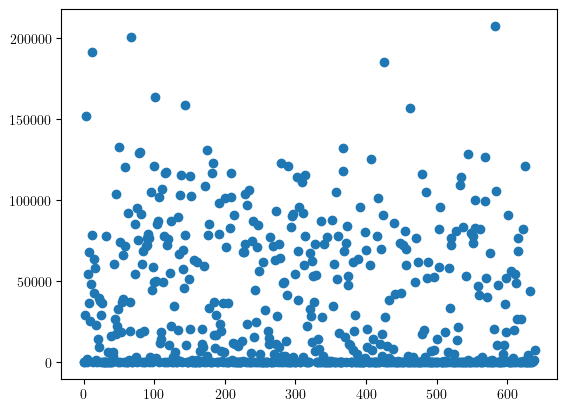

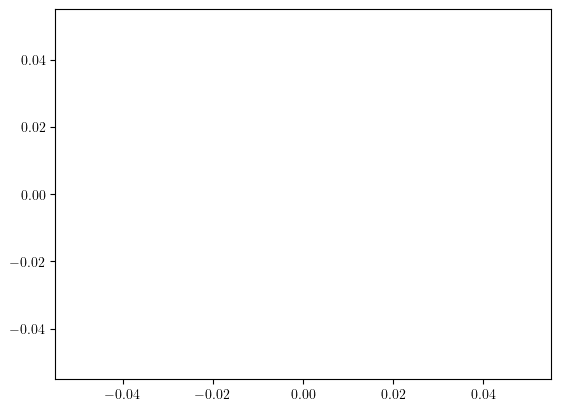

In [6]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [7]:
valid_arr_x_args = list(filter(lambda x: np.isclose(np.array(optimizer.history["Fs"])[x,0,1], 0), range(len(optimizer.history["Fs"])) ))
valid_HL_arr_x_args = list(filter(lambda x: np.isclose(np.array(optimizer.history["Fs"])[x,1,1], 0), range(len(optimizer.history["Fs"])) ))

valid_arr_x = np.array(optimizer.history["X"])[valid_arr_x_args, :]
valid_arr_AC = np.array(optimizer.history["Fs"])[valid_arr_x_args, 0, 2]

valid_HL_arr_x = np.array(optimizer.history["X"])[valid_HL_arr_x_args, :]
valid_arr_HL = np.array(optimizer.history["Fs"])[valid_HL_arr_x_args, 1, 2]

valid_arr_X_AC = list(zip(valid_arr_x, valid_arr_AC))
valid_arr_X_AC_srtd = sorted(valid_arr_X_AC, key=lambda X_AC: X_AC[1])

valid_arr_X_HL = list(zip(valid_HL_arr_x, valid_arr_HL))
valid_arr_X_HL_srtd = sorted(valid_arr_X_HL, key=lambda X_HL: X_HL[1])

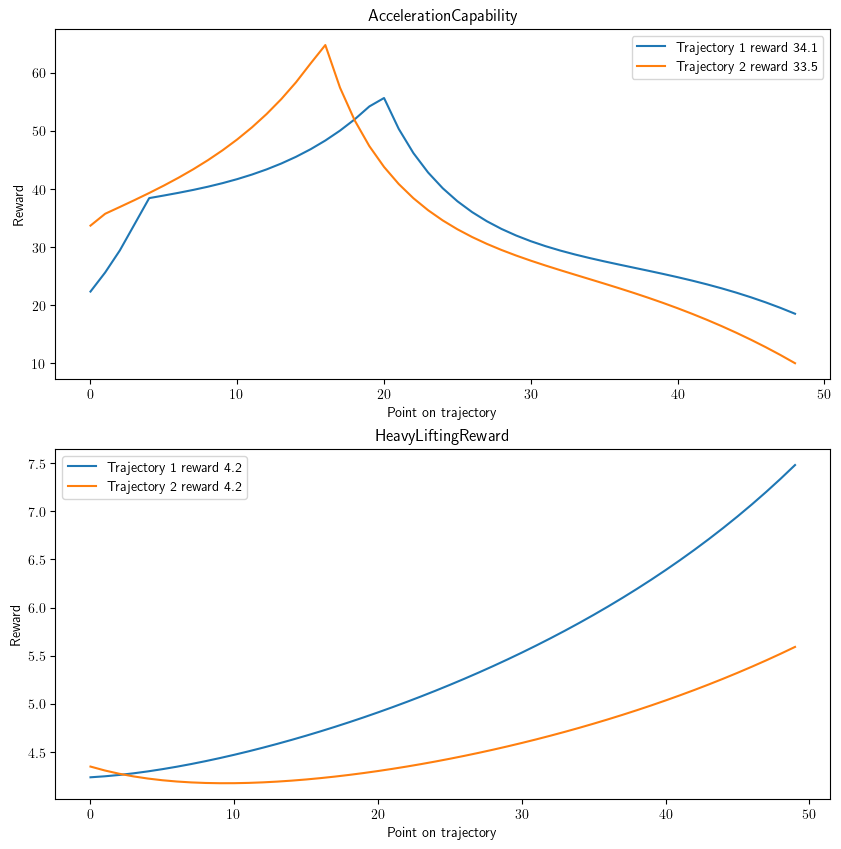

In [8]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
fig, axs, = plt.subplots(len(rewards_and_trajectories),1, figsize=(10,10))
for reward_n_traj, ax in zip(rewards_and_trajectories, axs):
    reward = reward_n_traj[0][1][0]
    trajectories = reward_n_traj[1]
    for traj, id in zip(trajectories, range(len(trajectories))):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, traj)
        cost = reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[0]
        reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
        ax.plot(reward_vector, label=f"Trajectory {id + 1} reward {cost.round(1)}") 
        ax.set_title(reward.__class__.__name__)
        ax.set_xlabel('Point on trajectory')
        ax.set_ylabel('Reward')
        ax.legend()
plt.savefig(os.path.join(path, "rewards_point.pdf"))

In [9]:
for id, (X, AC) in enumerate(valid_arr_X_AC_srtd):
    print(f"AC {id}: {AC}")

AC 0: 0.9426565694880347
AC 1: 1.77312464785495
AC 2: 2.250121749490147
AC 3: 3.500584525529803
AC 4: 3.5460801874703014
AC 5: 3.8079278278602127
AC 6: 4.241782430724002
AC 7: 4.464111817323983
AC 8: 4.878191452743789
AC 9: 5.269231931428322
AC 10: 5.579426463254764
AC 11: 5.6595756932422425
AC 12: 6.274413377595568
AC 13: 7.136640378984174
AC 14: 7.563970151062311
AC 15: 8.015896271985406
AC 16: 8.479690836756902
AC 17: 8.479690836756902
AC 18: 9.057264072687559
AC 19: 9.295267058453547
AC 20: 9.616494861877614
AC 21: 9.80008281128217
AC 22: 10.544578112458126
AC 23: 11.134875174165703
AC 24: 11.27997997819931
AC 25: 11.284730841925885
AC 26: 11.610150206270895
AC 27: 11.837410681514719
AC 28: 11.917949360809327
AC 29: 11.924036606362428
AC 30: 12.002758661971946
AC 31: 12.030486178734884
AC 32: 12.473870269650968
AC 33: 12.700915089031682
AC 34: 12.877994691205618
AC 35: 13.03789415037872
AC 36: 13.100971754316886
AC 37: 13.236205808962044
AC 38: 14.056757642129668
AC 39: 14.16661123

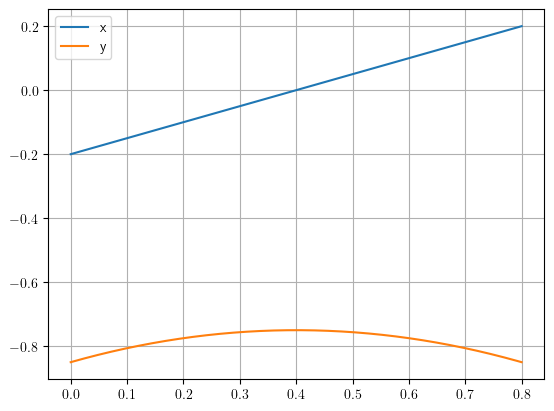

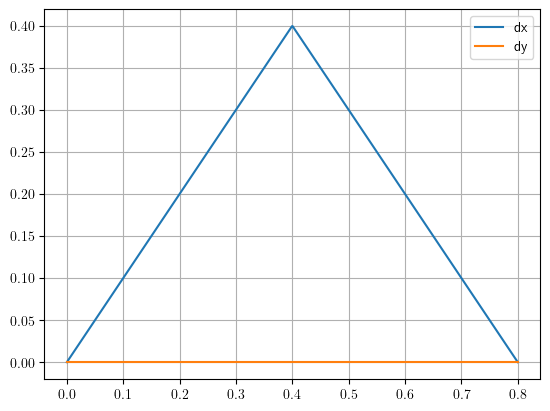

In [11]:
x_var = valid_arr_X_AC_srtd[-1][0]
problem.mutate_JP_by_xopt(x_var)
robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

name_ee = "EE"

# traj = vertical_trajectories[0][:,[0,2]]
traj =  step_trajectories[0][:,[0,2]]
test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)
time, traj6d, dtraj6d =  test.prepare_trajectory(robo)

path_1 = "results/test_2024-05-07_22-05-47_17reverse_RH5_2"

plt.plot(time, traj6d[:,0], label="x")
plt.plot(time, traj6d[:,2], label="y")
plt.legend()
plt.grid()
plt.savefig(os.path.join(path_1, "trajectory.svg"))
plt.figure()
plt.plot(time, dtraj6d[:,0], label="dx")
plt.plot(time, dtraj6d[:,2], label="dy")
plt.legend()
plt.grid()
plt.savefig(os.path.join(path_1, "dtrajectory.svg"))

In [14]:
import warnings
warnings.filterwarnings('ignore') 

# 11rev: ids = [44, 147, 411, 555]
#ids = [9, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230]
ids = [30, 70, 110, 150, 230]

AC_designs = []
AC2ids_designs = {}
valid_AC_arr_X_srtd = np.array([valid_arr_X_AC_srtd[i][0] for i in range(len(valid_arr_X_AC_srtd))])

for id in ids:
    AC_designs.append(valid_arr_X_AC_srtd[id][1])
    AC2ids_designs[AC_designs[-1]] = id

# sorted_ctrl_coeffs = [ctrl_HL[0] for ctrl_HL in sorted(zip(ctrl_coeffs, HL_designs), key=lambda x: x[1])]
print(AC_designs)

coeffs = []
func_ctrl_rewards = []
data = []
for id in ids:
    x_var = valid_AC_arr_X_srtd[id, :]
    problem.mutate_JP_by_xopt(x_var)
    robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

    name_ee = "EE"

    # traj = vertical_trajectories[0][:,[0,2]]
    traj =  step_trajectories[0][:,[0,2]]
    test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)

    time_arr, des_traj_6d, __ = test.prepare_trajectory(robo)
    # test.prepare_trajectory(robo)
    
    Kp, Kd, fun = test.optimize_control(robo)
    coeffs.append((x_var, Kp, Kd))
    func_ctrl_rewards.append(fun)
    test.Kp = Kp
    test.Kd = Kd
    
    # # q, vq, acc, tau, pos_ee, power
    data.append(test.simulate(robo, False))
    print(f"AC {id}: {func_ctrl_rewards[-1]}")

[12.002758661971946, 19.705811284434745, 22.707802061781432, 25.02234144907743, 30.864062393576255]
AC 30: 4.313356589392782
AC 70: 1.9321052665691358
AC 110: 1.5186226707132735


KeyboardInterrupt: 

In [15]:

power_arrs = [data[i][5] for i in range(len(data))]
pos_ee_arrs = [data[i][4] for i in range(len(data))]
tau_arrs = [data[i][3] for i in range(len(data))]


In [16]:

pathfile_ctrl = os.path.join(path_1, "AC_ctrl_coeffs.pkl")
with open(pathfile_ctrl, "wb") as f:
    dill.dump(coeffs, f)
    


In [17]:

pathfile_ctrl = os.path.join(path_1, "ctrl_rewards.pkl")
with open(pathfile_ctrl, "wb") as f:
    dill.dump(func_ctrl_rewards, f)

In [18]:
len(func_ctrl_rewards)
len(coeffs)

3

In [20]:

AC_designs = []
AC2ids_designs = {}
valid_arr_X_srtd = np.array([valid_arr_X_AC_srtd[i][0] for i in range(len(valid_arr_X_AC_srtd))])
for x_var, __, __ in coeffs:
    id_design = int(np.argwhere(np.all(valid_arr_X_srtd == x_var, axis=1))[0].squeeze())
    AC_designs.append(valid_arr_X_AC_srtd[id_design][1])
    AC2ids_designs[AC_designs[-1]] = id_design

sorted_ctrl_coeffs = [ctrl_AC[0] for ctrl_AC in sorted(zip(coeffs, AC_designs), key=lambda x: x[1])]
print(AC_designs)

[12.002758661971946, 19.705811284434745, 22.707802061781432]


In [29]:
from auto_robot_design.simulation.trajectory_movments import ControlOptProblem


ctrl_rews = []
data = []
for x_var, Kp, Kd in coeffs:
    problem.mutate_JP_by_xopt(x_var)
    robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

    name_ee = "EE"

    # traj = vertical_trajectories[1][:,[0,2]]
    traj =  step_trajectories[0][:,[0,2]]
    
    test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)
    ctrl_rew = ControlOptProblem(test, robo, xl=np.ones(4)*-1, xu=np.ones(4))
    
    ctrl_rews.append(ctrl_rew.evaluate(np.array([Kp[0,0], Kp[2,2], Kd[0,0], Kd[2,2]])))

    time_arr, des_traj_6d, __ = test.prepare_trajectory(robo)
    # test.prepare_trajectory(robo)
    test.Kp = Kp
    test.Kd = Kd
    
    # # q, vq, acc, tau, pos_ee, power
    data.append(test.simulate(robo, False))

power_arrs = [data[i][5] for i in range(len(data))]
pos_ee_arrs = [data[i][4] for i in range(len(data))]
tau_arrs = [data[i][3] for i in range(len(data))]
print(ctrl_rews)

[4.313356589392782, 1.9321052665691358, 1.5186226707132735]


In [30]:
cost

0

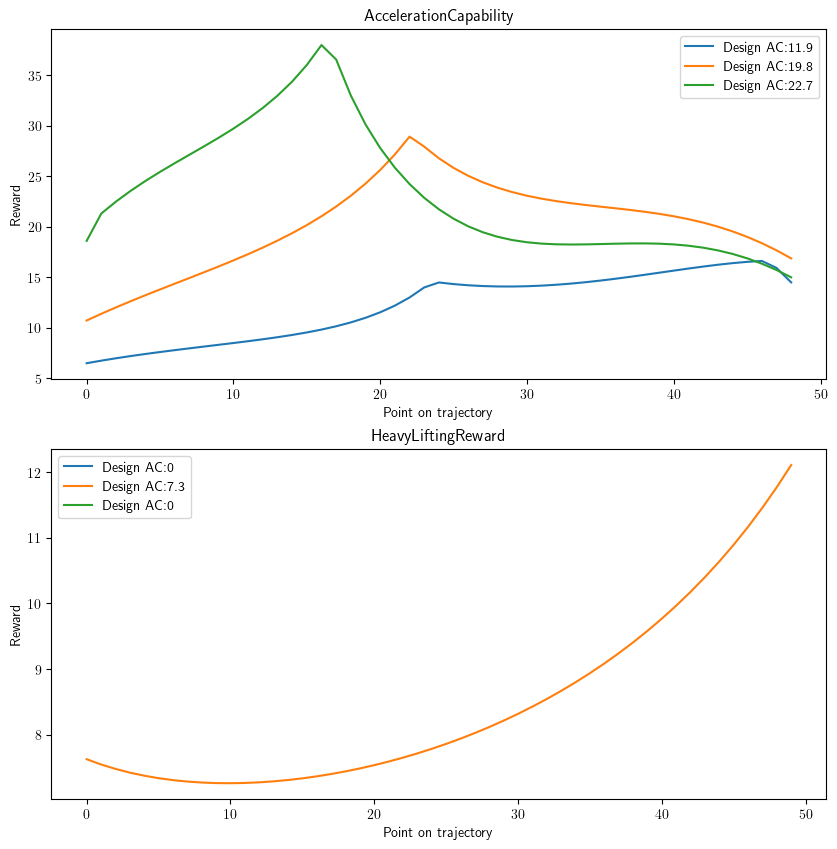

In [31]:
fig, axs, = plt.subplots(len(rewards_and_trajectories),1, figsize=(10,10))

for x_var, __, __ in coeffs:
    problem.mutate_JP_by_xopt(x_var)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
    for reward_n_traj, ax in zip(rewards_and_trajectories, axs):
        reward = reward_n_traj[0][1][0]
        trajectories = reward_n_traj[1][0]
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectories)
        cost = reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[0]
        reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
        # ax.plot(reward_vector, label=f"Trajectory {id + 1} reward {cost.round(1)}") 
        ax.plot(reward_vector, label=f"Design AC:{np.round(cost, 1)}") 
        ax.set_title(reward.__class__.__name__)
        ax.set_xlabel('Point on trajectory')
        ax.set_ylabel('Reward')
        ax.legend()
plt.savefig(os.path.join(path_1, "rewards_point_AC.svg"))

In [32]:
from auto_robot_design.description.builder import jps_graph2urdf_by_bulder


urdf_robot, __, __ = jps_graph2urdf_by_bulder(problem.graph, builder=builder)

pathfile_ctrl = os.path.join(path_1, "urdf_robot.urdf")
with open(pathfile_ctrl, "w") as f:
    f.write(urdf_robot)

In [33]:
pathfile_ctrl = os.path.join(path_1, "ctrl_rewards_test.pkl")
with open(pathfile_ctrl, "wb") as f:
    dill.dump(func_ctrl_rewards, f)

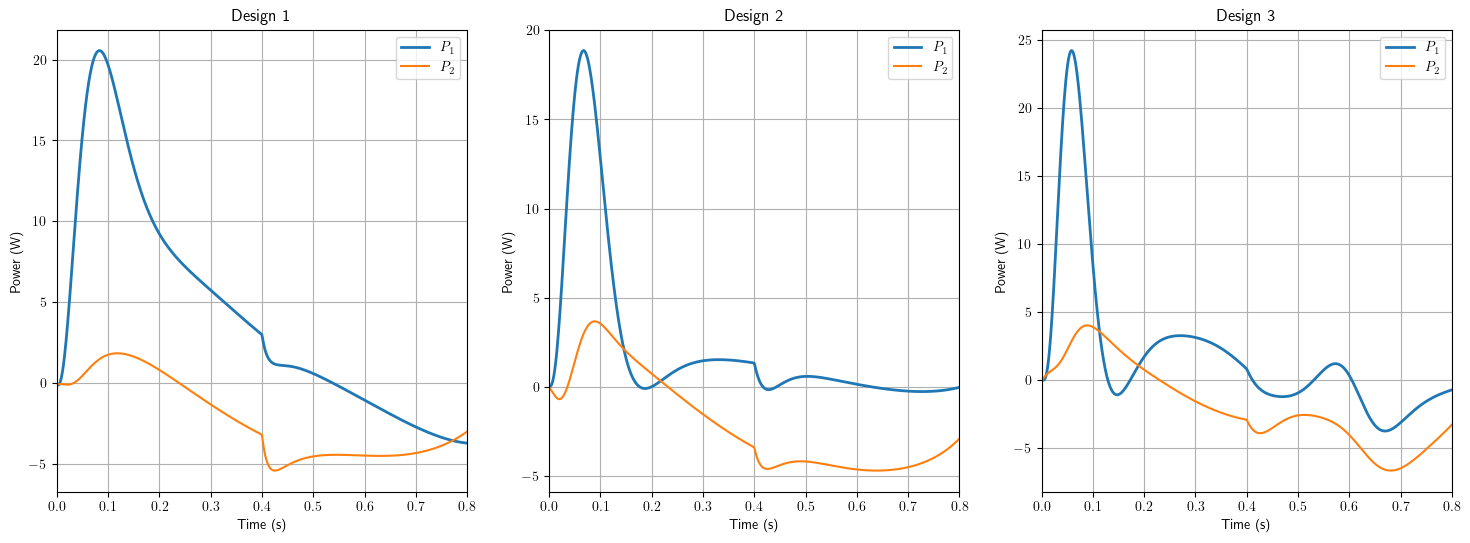

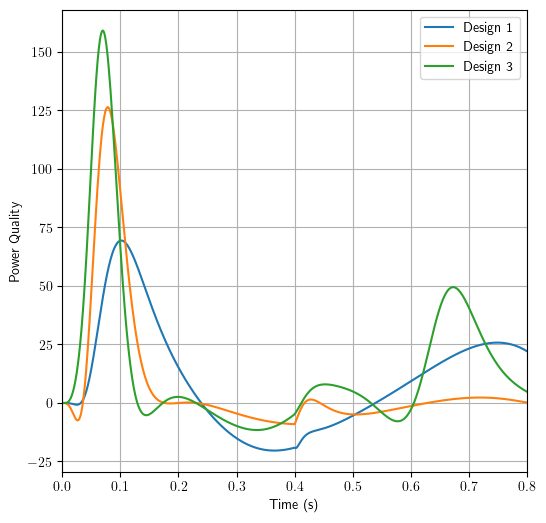

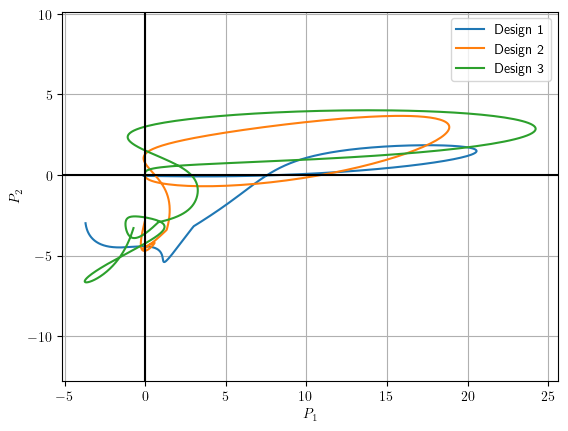

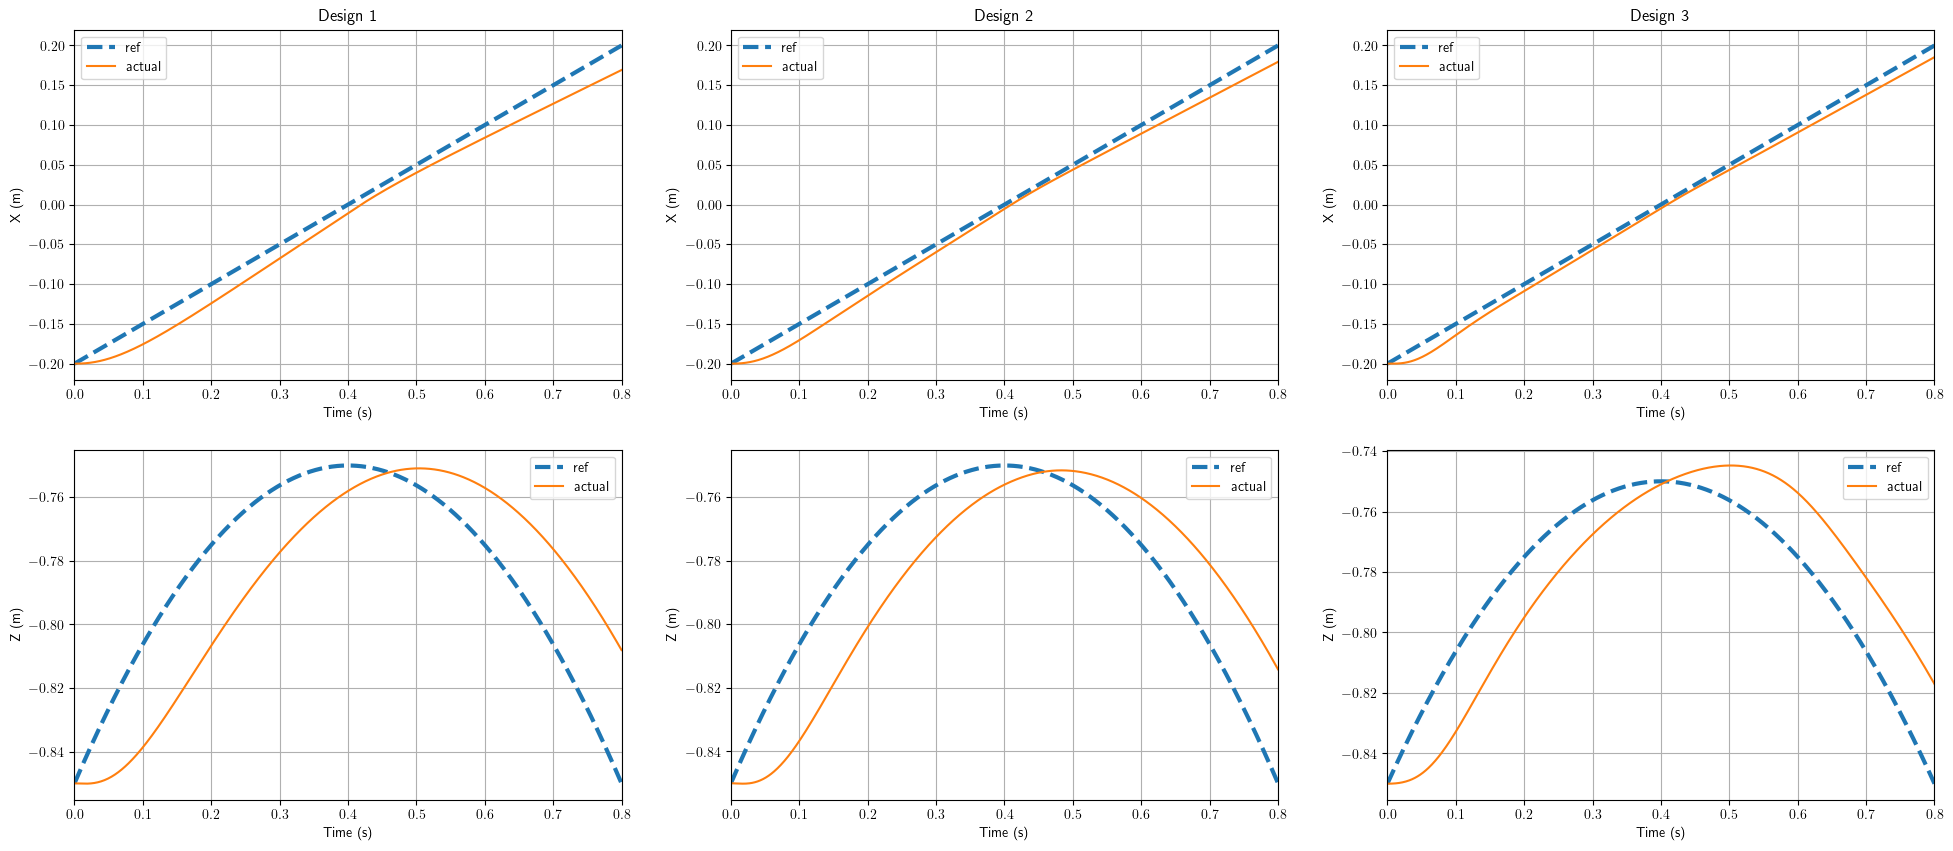

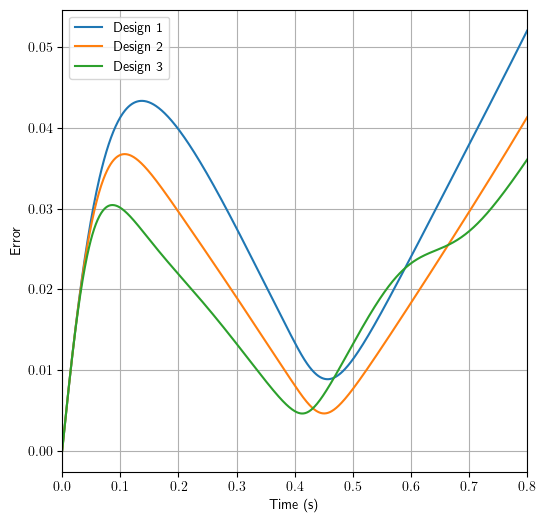

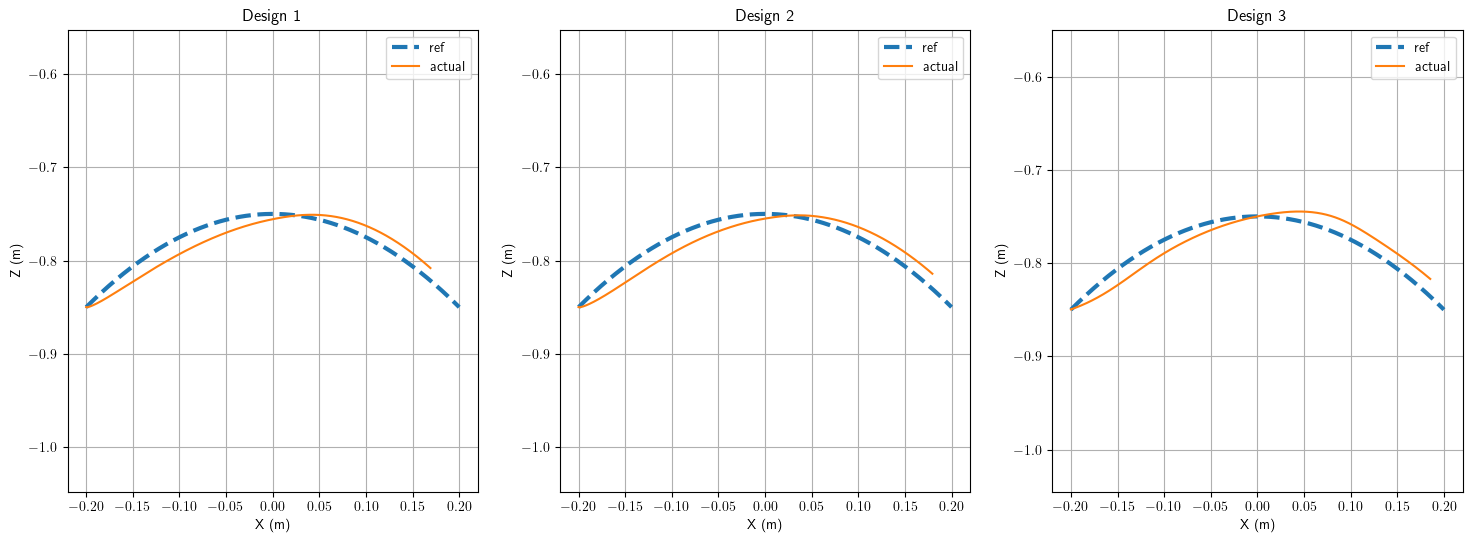

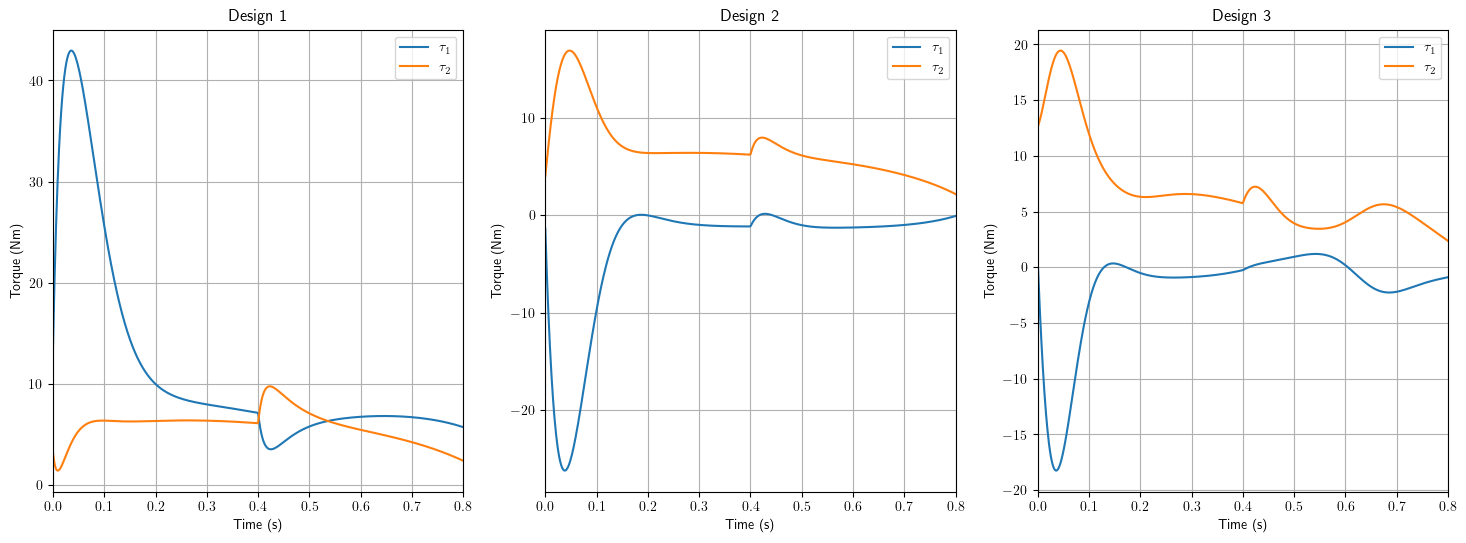

In [34]:
id2arrs = lambda arrs, ids: [arrs[id] for id in ids]
mean_powers, sum_power, abs_powers =  eval.compare_power_quality(time_arr, power_arrs, True, os.path.join(path_1, "AC"))
mean_errors = eval.compare_movments_in_xz_plane(time_arr, pos_ee_arrs, des_traj_6d[:,:3], True, os.path.join(path_1, "AC"))
max_torques, mean_torques = eval.compare_torque_evaluation(time_arr, tau_arrs, True, os.path.join(path_1, "AC"))

# mean_powers, sum_power, abs_powers =  eval.compare_power_quality(time_arr, id2arrs(power_arrs, [2,-1]), True)
# mean_errors = eval.compare_movments_in_xz_plane(time_arr, id2arrs(pos_ee_arrs, [2,-1]), des_traj_6d[:,:3], True)
# max_torques, mean_torques = eval.compare_torque_evaluation(time_arr, id2arrs(tau_arrs, [2,-1]), True)

In [35]:
print(f"Mean power: {mean_powers} \n Sum power: {sum_power} \n Abs power: {abs_powers}")
print(f"Mean error: {mean_errors}")
print(f"Max torque: {max_torques.T}\n Mean torque: {mean_torques.T}")

Mean power: [8.43458916 5.3662589  6.41203866] 
 Sum power: [1.59203993e+03 1.25440193e+02 6.79457634e-02] 
 Abs power: [6747.67132549 4293.00711997 5129.63092967]
Mean error: [0.02827086 0.0218169  0.01970937]
Max torque: [[42.95775284 26.20815    18.24532106]
 [ 9.74556518 16.92038416 19.44777168]]
 Mean torque: [[11.405653    3.30498773  2.26323074]
 [ 5.79350104  6.86003231  6.98051596]]


In [44]:
np.sum(max_torques, axis=1)[:,np.newaxis]

array([[52.70331803],
       [43.12853416],
       [37.69309275]])

In [48]:
np.hstack((mean_torques, np.linalg.norm(mean_torques, axis=1)[:,np.newaxis]))

array([[11.405653  ,  5.79350104, 12.79271569],
       [ 3.30498773,  6.86003231,  7.61465608],
       [ 2.26323074,  6.98051596,  7.33824342]])

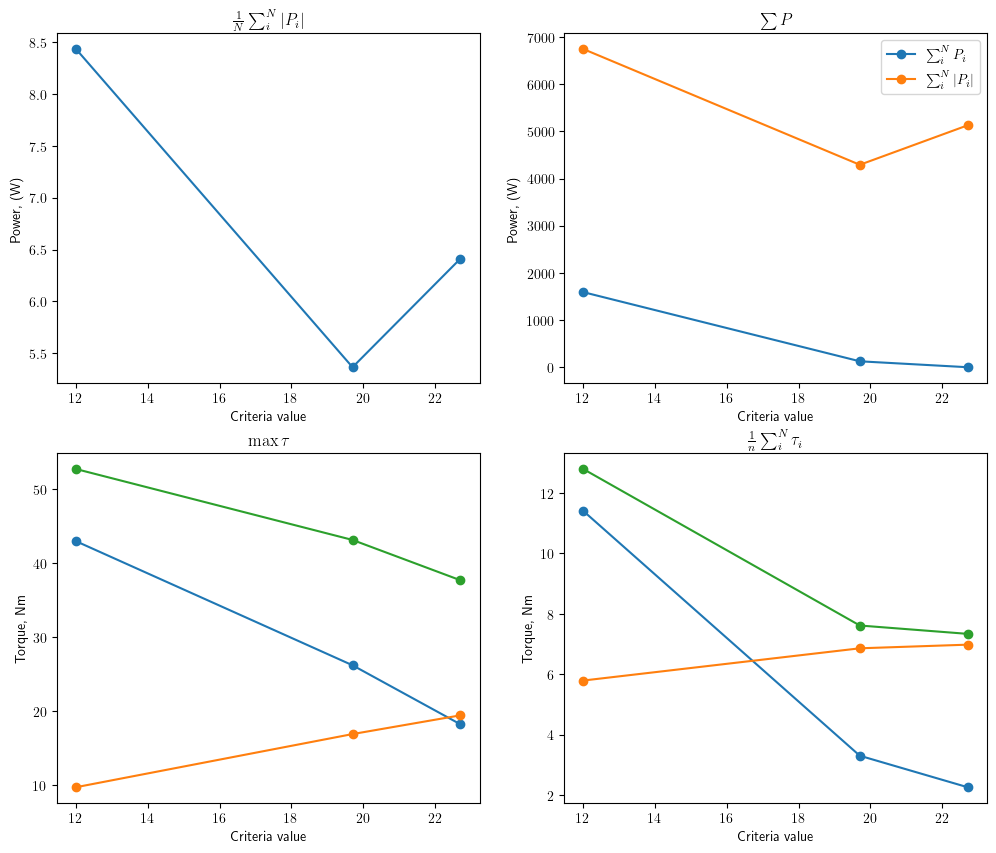

In [49]:
AC_sorted = sorted(AC_designs)

fig = plt.figure(figsize=(12, 10))
plot_name = [[r"$\frac{1}{N}\sum_i^N |P_i|$", r"$\sum P$"], [r"$\max \tau$", r"$\frac{1}{n}\sum_i^N \tau_i$"]]
ylabel = ["Power, (W)", "Power, (W)", "Torque, Nm", "Torque, Nm"]

axs = fig.subplot_mosaic(plot_name)
for reward, ax, ylab in zip([mean_powers, [sum_power, abs_powers], np.hstack((max_torques, np.sum(max_torques, axis=1)[:,np.newaxis])), np.hstack((mean_torques, np.linalg.norm(mean_torques, axis=1)[:,np.newaxis]))], np.array(plot_name).flatten(), ylabel):
    if "$\sum P$" == ax:
        axs[ax].plot(AC_sorted, reward[0], "o-", label="$\sum_i^N P_i$")
        axs[ax].plot(AC_sorted, reward[1], "o-", label="$\sum_i^N |P_i|$")
        axs[ax].legend()
    else:
        axs[ax].plot(AC_sorted, reward, "o-")
    axs[ax].set_title(ax)
    axs[ax].set_xlabel('Criteria value')
    axs[ax].set_ylabel(ylab)
    
plt.savefig(os.path.join(path_1, "AC_power_torque.svg"))

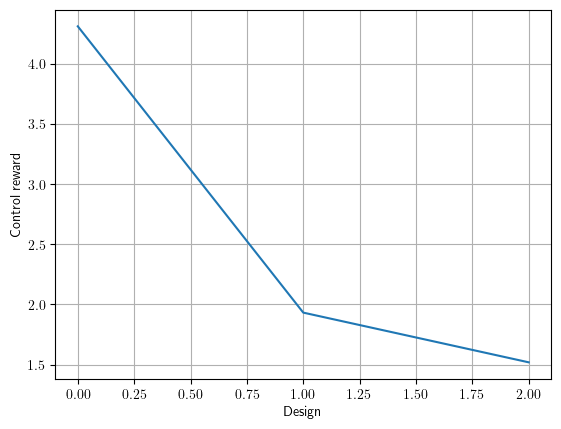

In [38]:
plt.plot(ctrl_rews)
plt.xlabel("Design")
plt.ylabel("Control reward")
plt.grid()
plt.savefig(os.path.join(path_1, "AC_ctrl_rewards.svg"))


In [39]:
np.sum(max_torques,axis=1)

array([52.70331803, 43.12853416, 37.69309275])

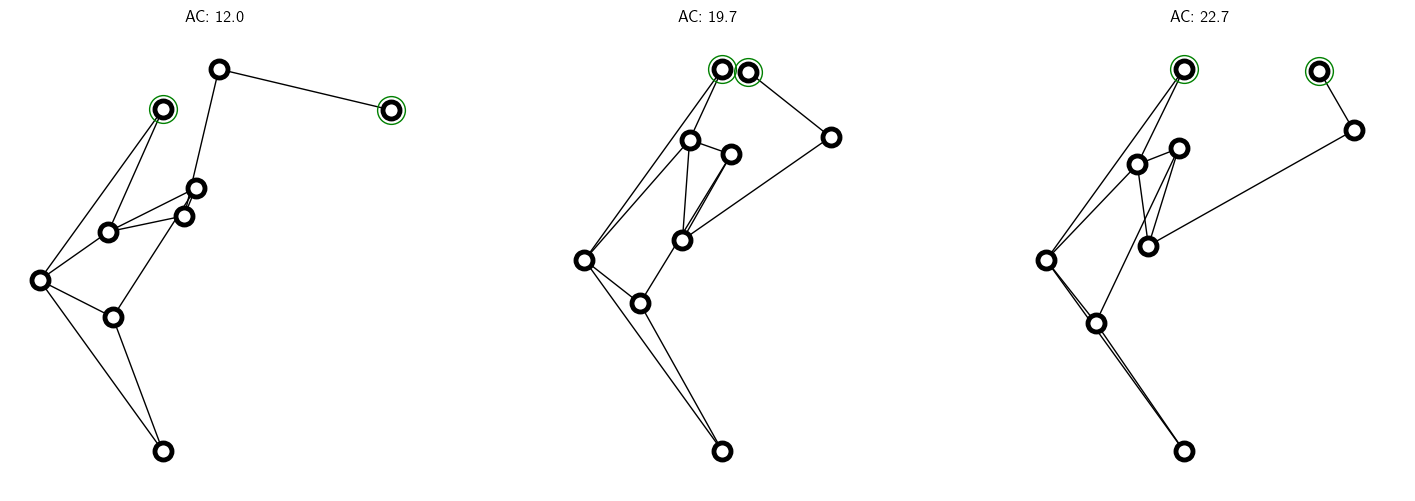

In [40]:
plt.figure(figsize=(len(AC_sorted)*6, 6))
for AC in AC_sorted:
    plt.subplot(1, len(AC_sorted), AC_sorted.index(AC) + 1)
    id_design = AC2ids_designs[AC]
    problem.mutate_JP_by_xopt(valid_arr_X_srtd[id_design])
    draw_joint_point(problem.graph)
    plt.legend('',frameon=False)
    plt.title(f"AC: {np.round(AC,1)}")

plt.savefig(os.path.join(path_1, "AC_designs.pdf"))

In [10]:
for id, (__, HL) in enumerate(valid_arr_X_HL_srtd):
    print(f"Design {id} HL: {HL}")

pathfile_ctrl = os.path.join(path, "HL_ctrl_coeffs.pkl")
with open(pathfile_ctrl, "rb") as f:
    coeffs = dill.load(f)


Design 0 HL: 0.0
Design 1 HL: 0.0
Design 2 HL: 0.0
Design 3 HL: 0.0
Design 4 HL: 0.0
Design 5 HL: 0.0
Design 6 HL: 0.0
Design 7 HL: 0.0
Design 8 HL: 0.0
Design 9 HL: 0.0
Design 10 HL: 0.0
Design 11 HL: 0.0
Design 12 HL: 0.0
Design 13 HL: 0.0
Design 14 HL: 0.0
Design 15 HL: 0.0
Design 16 HL: 0.0
Design 17 HL: 0.0
Design 18 HL: 0.0
Design 19 HL: 0.0
Design 20 HL: 0.0
Design 21 HL: 0.0
Design 22 HL: 0.0
Design 23 HL: 0.0
Design 24 HL: 0.0
Design 25 HL: 0.0
Design 26 HL: 0.0
Design 27 HL: 0.0
Design 28 HL: 0.0
Design 29 HL: 0.0
Design 30 HL: 0.0
Design 31 HL: 0.0
Design 32 HL: 0.0
Design 33 HL: 0.0
Design 34 HL: 0.0
Design 35 HL: 0.0
Design 36 HL: 0.0
Design 37 HL: 0.0
Design 38 HL: 0.0
Design 39 HL: 0.0
Design 40 HL: 0.0
Design 41 HL: 0.0
Design 42 HL: 0.0
Design 43 HL: 0.0
Design 44 HL: 0.0
Design 45 HL: 0.0
Design 46 HL: 0.0
Design 47 HL: 0.0
Design 48 HL: 0.0
Design 49 HL: 0.0
Design 50 HL: 0.0
Design 51 HL: 0.0
Design 52 HL: 0.0
Design 53 HL: 0.0
Design 54 HL: 0.0
Design 55 HL: 0.0
De

In [67]:
#1_RH5: ids = [58, 165, 284, 365, -1]
#2_RH5: ids = [121, 185, 271, 363, -1]
#8_RH5: ids = [123, 183, 246, 287, -1]

HL_designs = []
HL2ids_designs = {}
valid_HL_arr_X_srtd = np.array([valid_arr_X_HL_srtd[i][0] for i in range(len(valid_arr_X_HL_srtd))])

for id in ids:
    HL_designs.append(valid_arr_X_HL_srtd[id][1])
    HL2ids_designs[HL_designs[-1]] = id

# sorted_ctrl_coeffs = [ctrl_HL[0] for ctrl_HL in sorted(zip(ctrl_coeffs, HL_designs), key=lambda x: x[1])]
print(HL_designs)

coeffs = []

data = []
for id in ids:
    x_var = valid_HL_arr_X_srtd[id, :]
    problem.mutate_JP_by_xopt(x_var)
    robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

    name_ee = "EE"

    traj = vertical_trajectories[0][:,[0,2]]
    # traj =  step_trajectories[0][:,[0,2]]
    test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)

    time_arr, des_traj_6d, __ = test.prepare_trajectory(robo)
    # test.prepare_trajectory(robo)
    
    Kp, Kd = test.optimize_control(robo)
    coeffs.append((x_var, Kp, Kd))
    
    test.Kp = Kp
    test.Kd = Kd
    
    # # q, vq, acc, tau, pos_ee, power
    data.append(test.simulate(robo, False))

power_arrs = [data[i][5] for i in range(len(data))]
pos_ee_arrs = [data[i][4] for i in range(len(data))]
tau_arrs = [data[i][3] for i in range(len(data))]


pathfile_ctrl = os.path.join(path, "HL_ctrl_coeffs.pkl")

with open(pathfile_ctrl, "wb") as f:
    dill.dump(coeffs, f)

[6.138121936244586, 12.087804844012485, 18.08291991377449, 24.11957415096034, 27.434431013601873]
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/home/yefim-work/miniconda3/envs/j_moves/lib/python3.9/site-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

In [11]:
HL_designs = []
HL2ids_designs = {}
valid_HL_arr_X_srtd = np.array([valid_arr_X_HL_srtd[i][0] for i in range(len(valid_arr_X_HL_srtd))])

for x_var, __, __ in coeffs:
    id_design = int(np.argwhere(np.all(valid_HL_arr_X_srtd == x_var, axis=1))[0].squeeze())
    HL_designs.append(valid_arr_X_HL_srtd[id_design][1])
    HL2ids_designs[HL_designs[-1]] = id_design
    
    
sorted_ctrl_coeffs = [ctrl_HL[0] for ctrl_HL in sorted(zip(ctrl_coeffs, HL_designs), key=lambda x: x[1])]
print(HL_designs)

[6.138121936244586, 12.087804844012485, 18.08291991377449, 24.11957415096034, 27.434431013601873]


In [14]:
from auto_robot_design.simulation.trajectory_movments import ControlOptProblem

data = []
ctrl_rews = []
for x_var, Kp, Kd in coeffs:
    problem.mutate_JP_by_xopt(x_var)
    robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

    name_ee = "EE"

    traj = vertical_trajectories[0][:,[0,2]]
    # traj =  step_trajectories[0][:,[0,2]]
    test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)
    ctrl_rew = ControlOptProblem(test, robo, xl=np.ones(4)*-1, xu=np.ones(4))
    
    ctrl_rews.append(ctrl_rew.evaluate(np.array([Kp[0,0], Kp[2,2], Kd[0,0], Kd[2,2]])))

    time_arr, des_traj_6d, __ = test.prepare_trajectory(robo)
    # test.prepare_trajectory(robo)
    test.Kp = Kp
    test.Kd = Kd

    # # q, vq, acc, tau, pos_ee, power
    data.append(test.simulate(robo, False))

power_arrs = [data[i][5] for i in range(len(data))]
pos_ee_arrs = [data[i][4] for i in range(len(data))]
tau_arrs = [data[i][3] for i in range(len(data))]
print(ctrl_rews)

/home/yefim-work/miniconda3/envs/j_moves/lib/python3.9/site-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

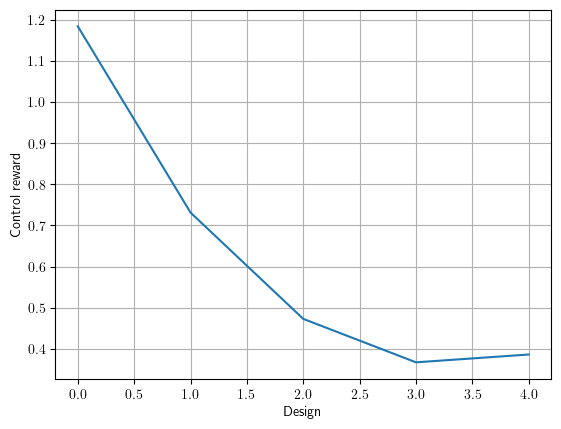

In [18]:
plt.plot(ctrl_rews)
plt.xlabel("Design")
plt.ylabel("Control reward")
plt.grid()
plt.savefig(os.path.join(path, "HL_ctrl_rewards.svg"))

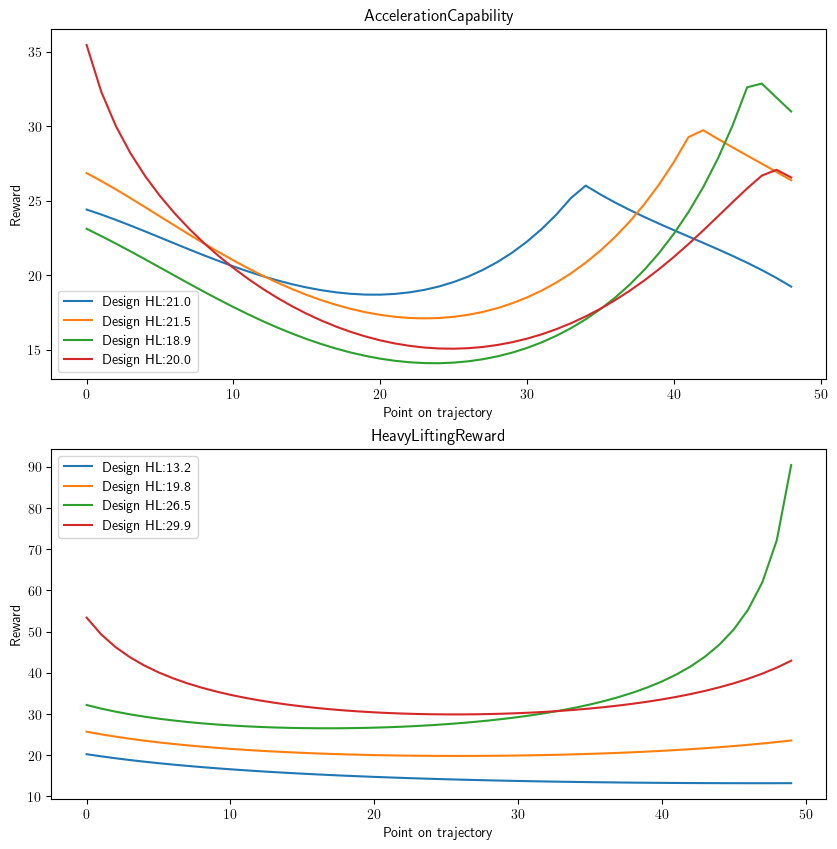

In [19]:
fig, axs, = plt.subplots(len(rewards_and_trajectories),1, figsize=(10,10))
s
for x_var, __, __ in coeffs[1:]:
    problem.mutate_JP_by_xopt(x_var)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
    for reward_n_traj, ax in zip(rewards_and_trajectories, axs):
        reward = reward_n_traj[0][1][0]
        trajectories = reward_n_traj[1][0]
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectories)
        cost = reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[0]
        reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
        # ax.plot(reward_vector, label=f"Trajectory {id + 1} reward {cost.round(1)}") 
        ax.plot(reward_vector, label=f"Design HL:{np.round(cost, 1)}") 
        ax.set_title(reward.__class__.__name__)
        ax.set_xlabel('Point on trajectory')
        ax.set_ylabel('Reward')
        ax.legend()
plt.savefig(os.path.join(path, "rewards_point_HL.svg"))

In [21]:
from auto_robot_design.description.builder import jps_graph2urdf_by_bulder


urdf_robot, __, __ = jps_graph2urdf_by_bulder(problem.graph, builder=builder)

pathfile_ctrl = os.path.join(path, "HL_best_urdf_robot.urdf")
with open(pathfile_ctrl, "w") as f:
    f.write(urdf_robot)

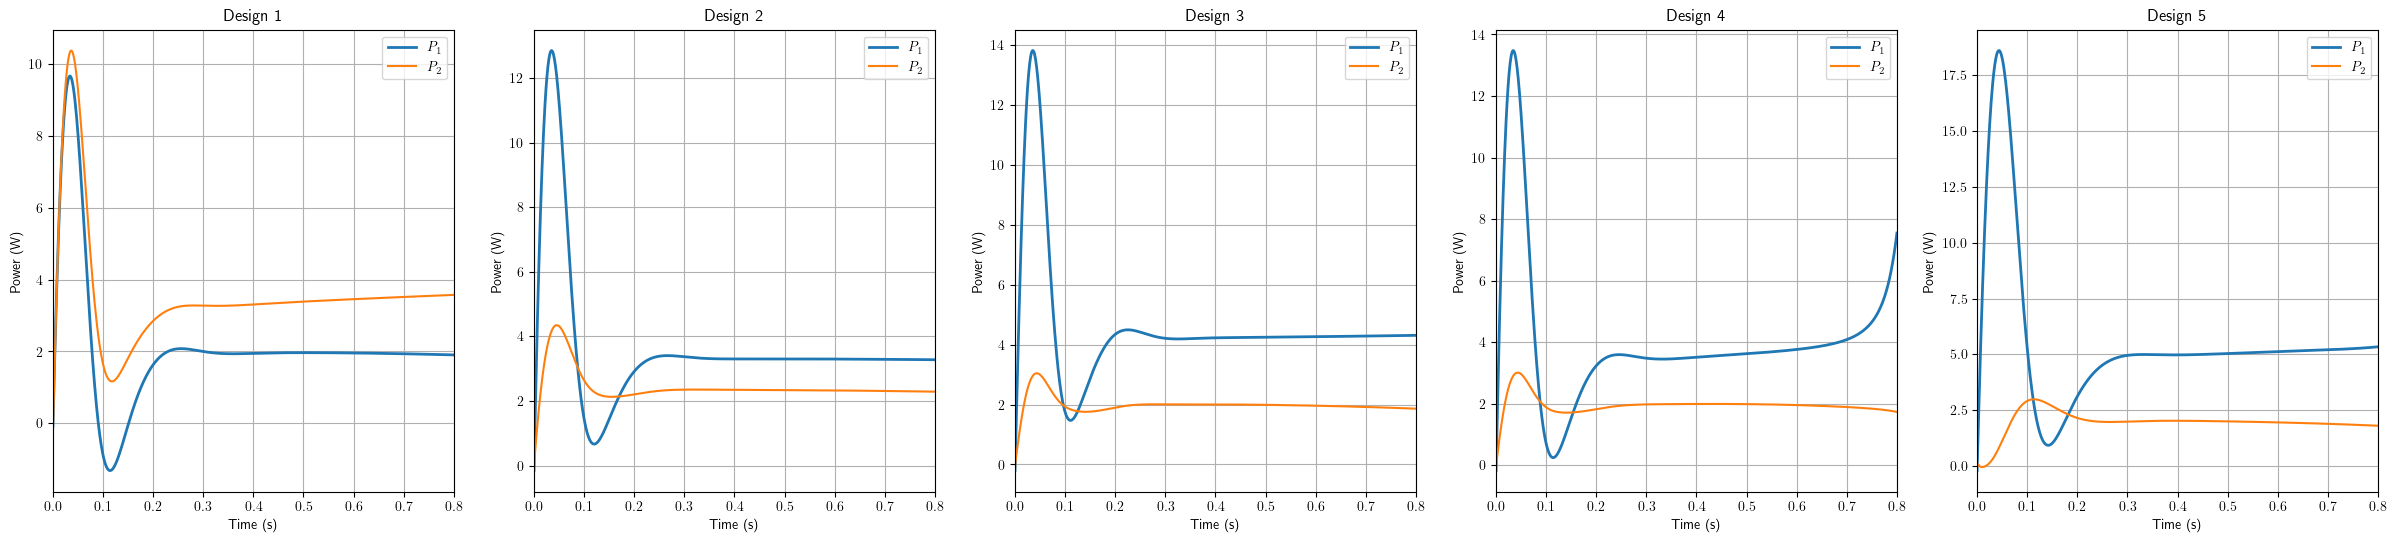

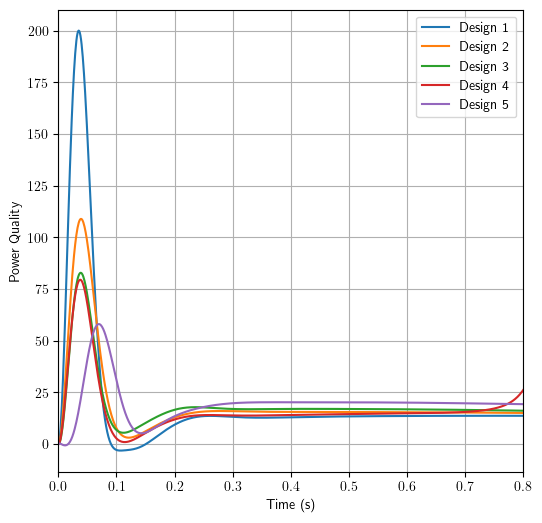

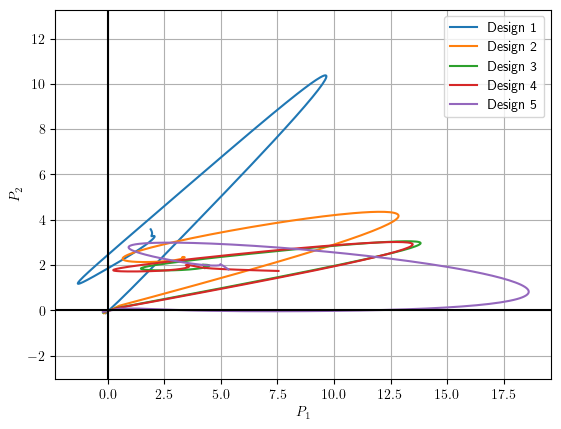

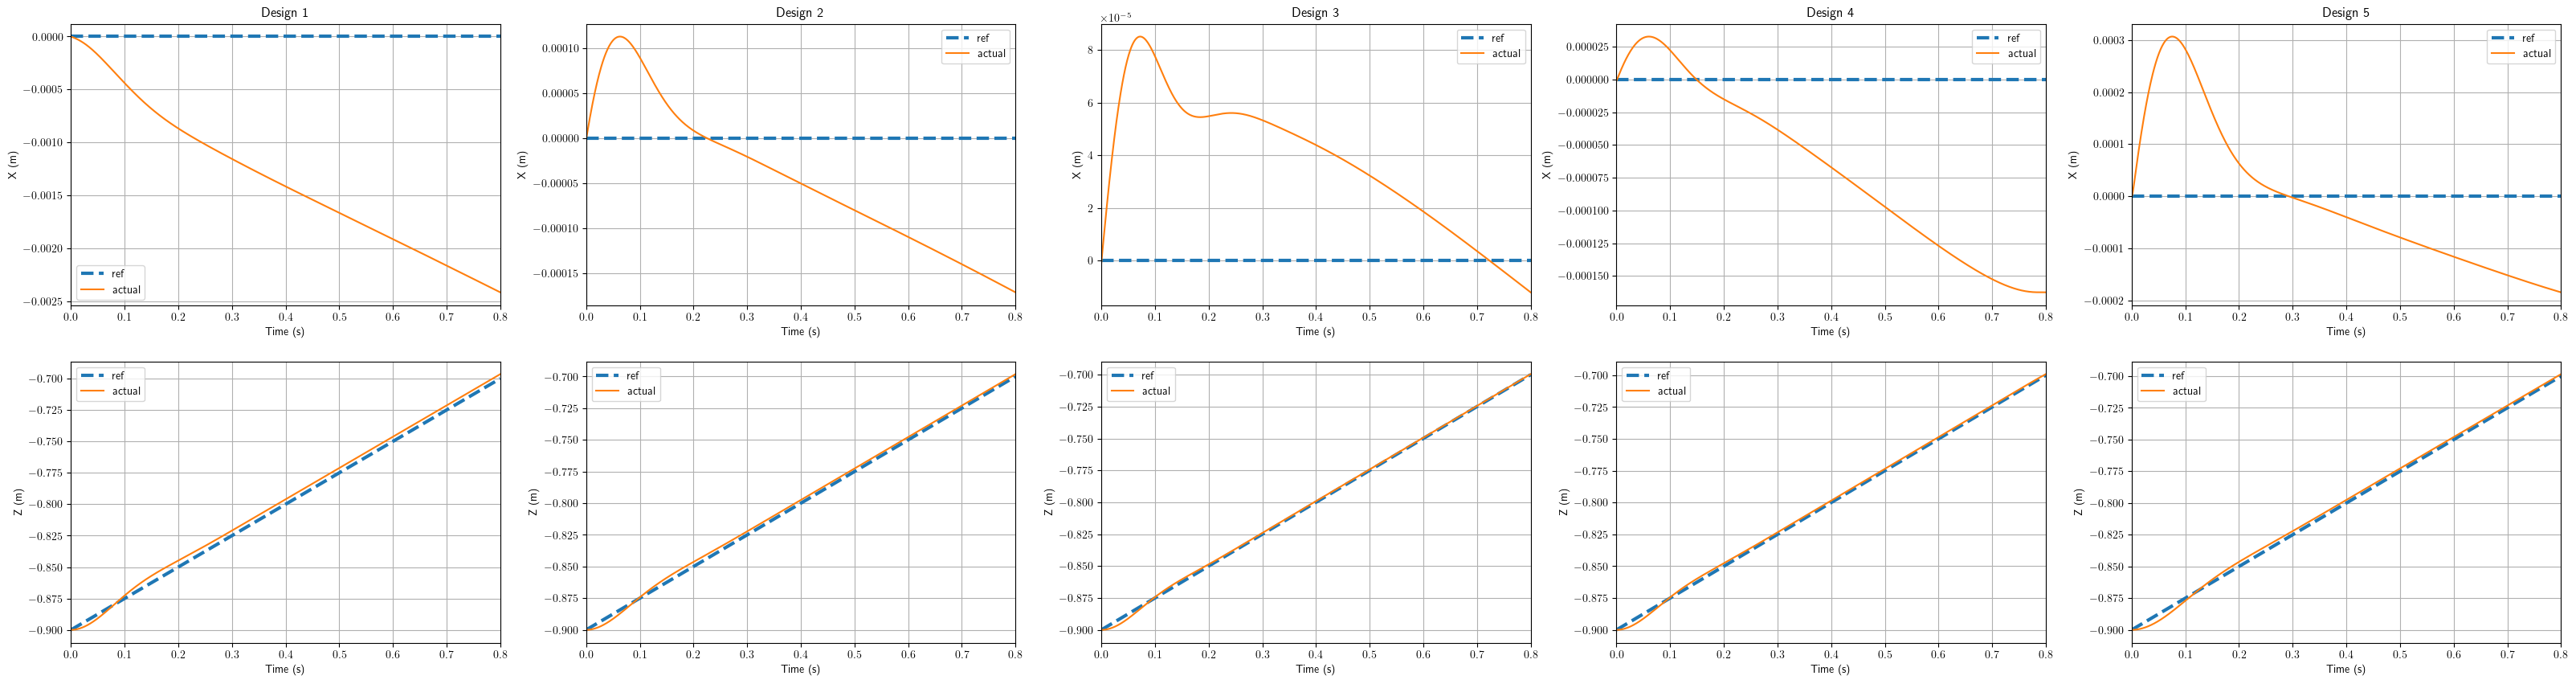

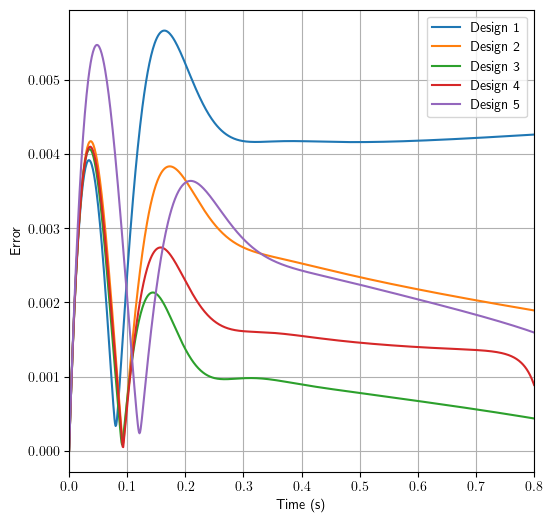

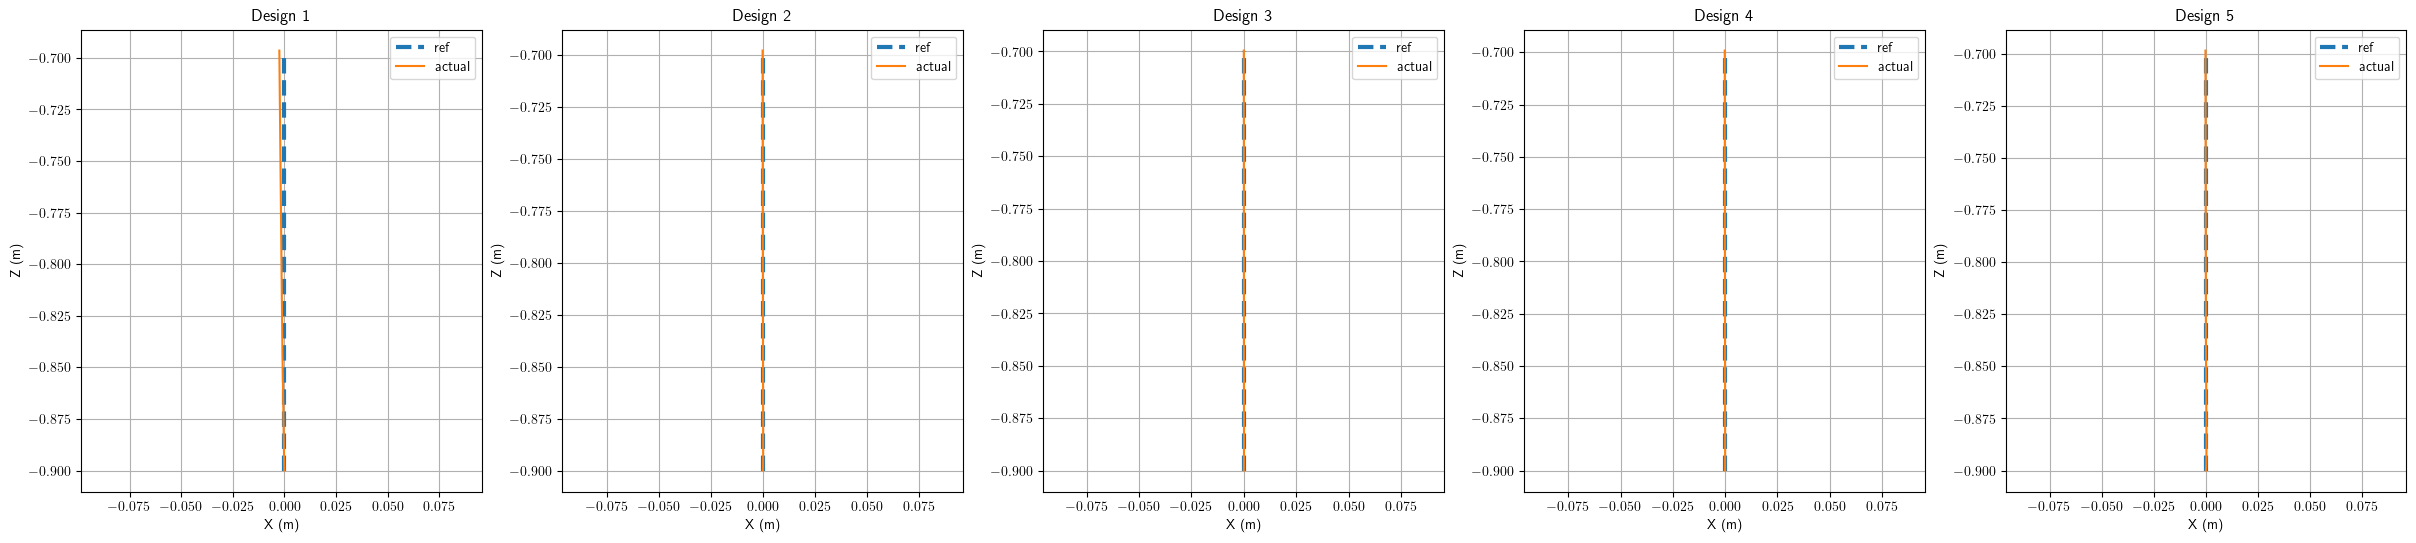

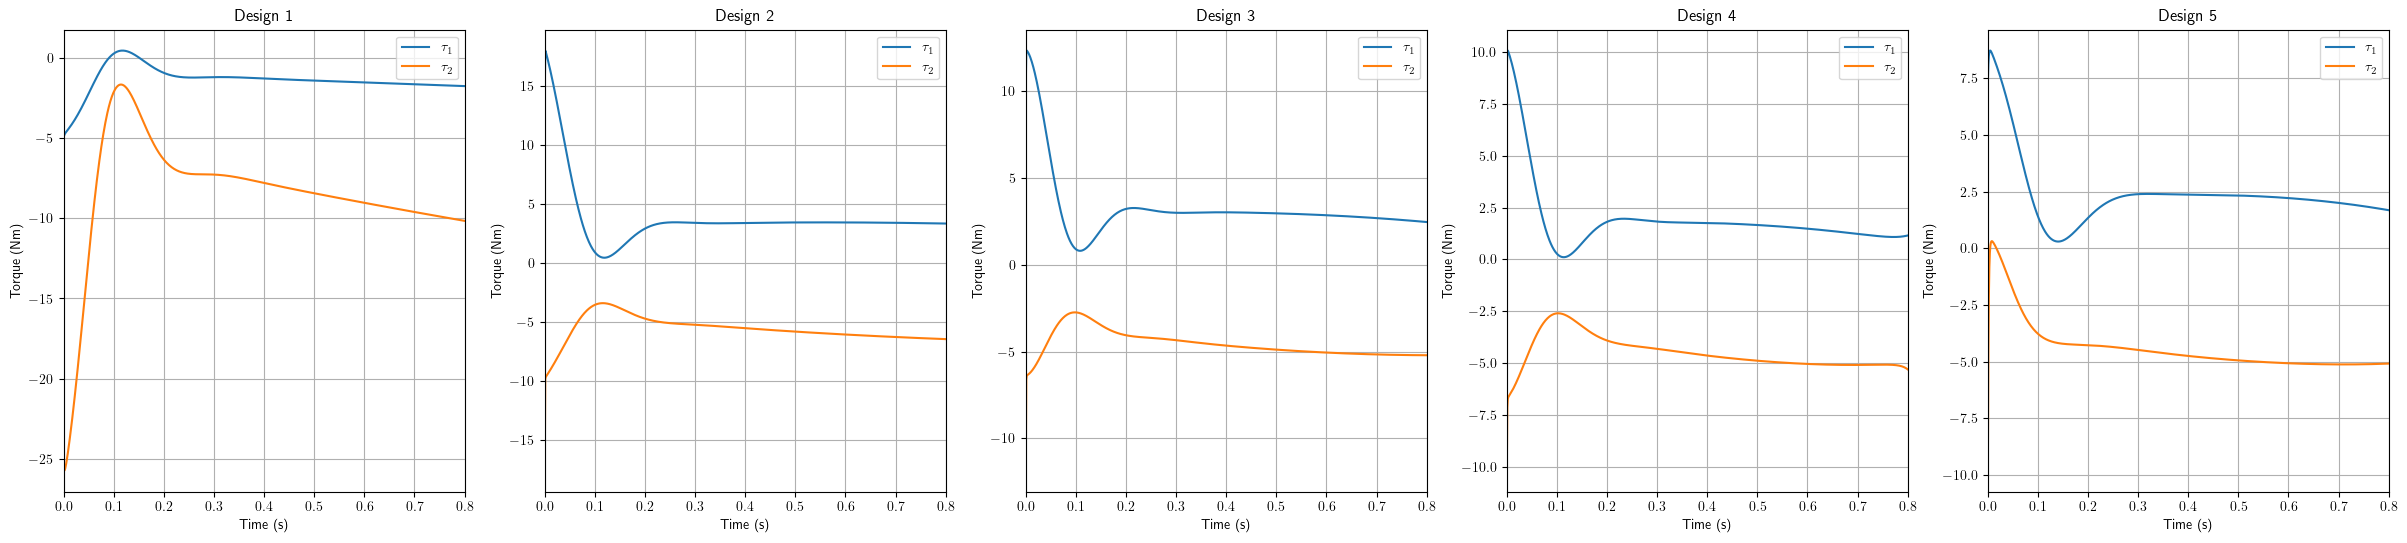

In [22]:
id2arrs = lambda arrs, ids: [arrs[id] for id in ids]
mean_powers, sum_power, abs_powers =  eval.compare_power_quality(time_arr, power_arrs, True, os.path.join(path, "HL"))
mean_errors = eval.compare_movments_in_xz_plane(time_arr, pos_ee_arrs, des_traj_6d[:,:3], True, os.path.join(path, "HL"))
max_torques, mean_torques = eval.compare_torque_evaluation(time_arr, tau_arrs, True, os.path.join(path, "HL"))

In [23]:
print(f"Mean power: {mean_powers}, Sum power: {sum_power}, Abs power: {abs_powers}")
print(f"Mean error: {mean_errors}")
print(f"Max torque: {max_torques}, Mean torque: {mean_torques}")

Mean power: [5.79390301 6.07332907 6.55627478 6.00805001 7.52533675], Sum power: [4534.17838137 4858.08267174 5244.40770291 4805.97345192 6018.97002747], Abs power: [4635.12241012 4858.66325866 5245.01982176 4806.440004   6020.2694013 ]
Mean error: [0.00408956 0.00250976 0.00109631 0.00170782 0.00251663]
Max torque: [[ 4.89999879 25.73352125]
 [18.03134238 17.55626281]
 [12.33255319 11.85374997]
 [10.06712422 10.18613395]
 [ 8.7194074   9.80198866]], Mean torque: [[1.4006212  8.42072328]
 [3.82479515 5.57719605]
 [3.21328939 4.57391935]
 [1.88587456 4.5214856 ]
 [2.39039602 4.3950946 ]]


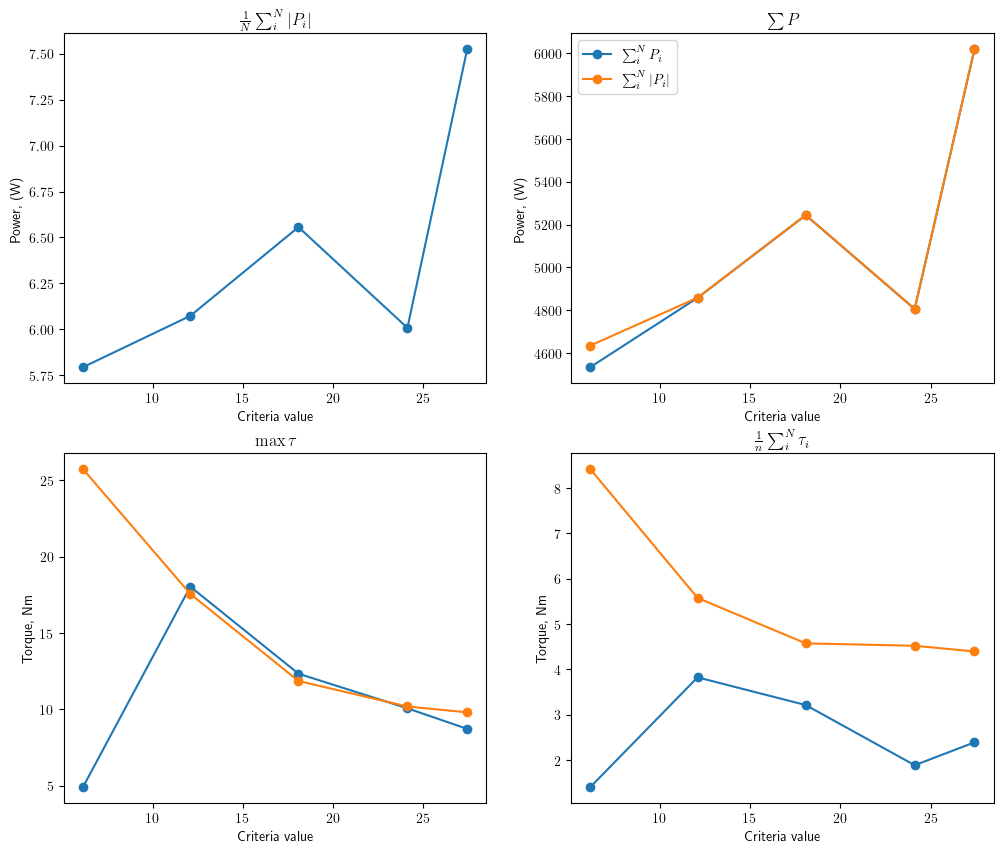

In [27]:
HL_sorted = sorted(HL_designs)

fig = plt.figure(figsize=(12, 10))
plot_name = [[r"$\frac{1}{N}\sum_i^N |P_i|$", r"$\sum P$"], [r"$\max \tau$", r"$\frac{1}{n}\sum_i^N \tau_i$"]]
ylabel = ["Power, (W)", "Power, (W)", "Torque, Nm", "Torque, Nm"]

axs = fig.subplot_mosaic(plot_name)
for reward, ax, ylab in zip([mean_powers, [sum_power, abs_powers], max_torques, mean_torques], np.array(plot_name).flatten(), ylabel):
    if "$\sum P$" == ax:
        axs[ax].plot(HL_sorted, reward[0], "o-", label="$\sum_i^N P_i$")
        axs[ax].plot(HL_sorted, reward[1], "o-", label="$\sum_i^N |P_i|$")
        axs[ax].legend()
    else:
        axs[ax].plot(HL_sorted, reward, "o-")
    axs[ax].set_title(ax)
    axs[ax].set_xlabel('Criteria value')
    axs[ax].set_ylabel(ylab)
plt.savefig(os.path.join(path, "HL_power_torque.svg"))

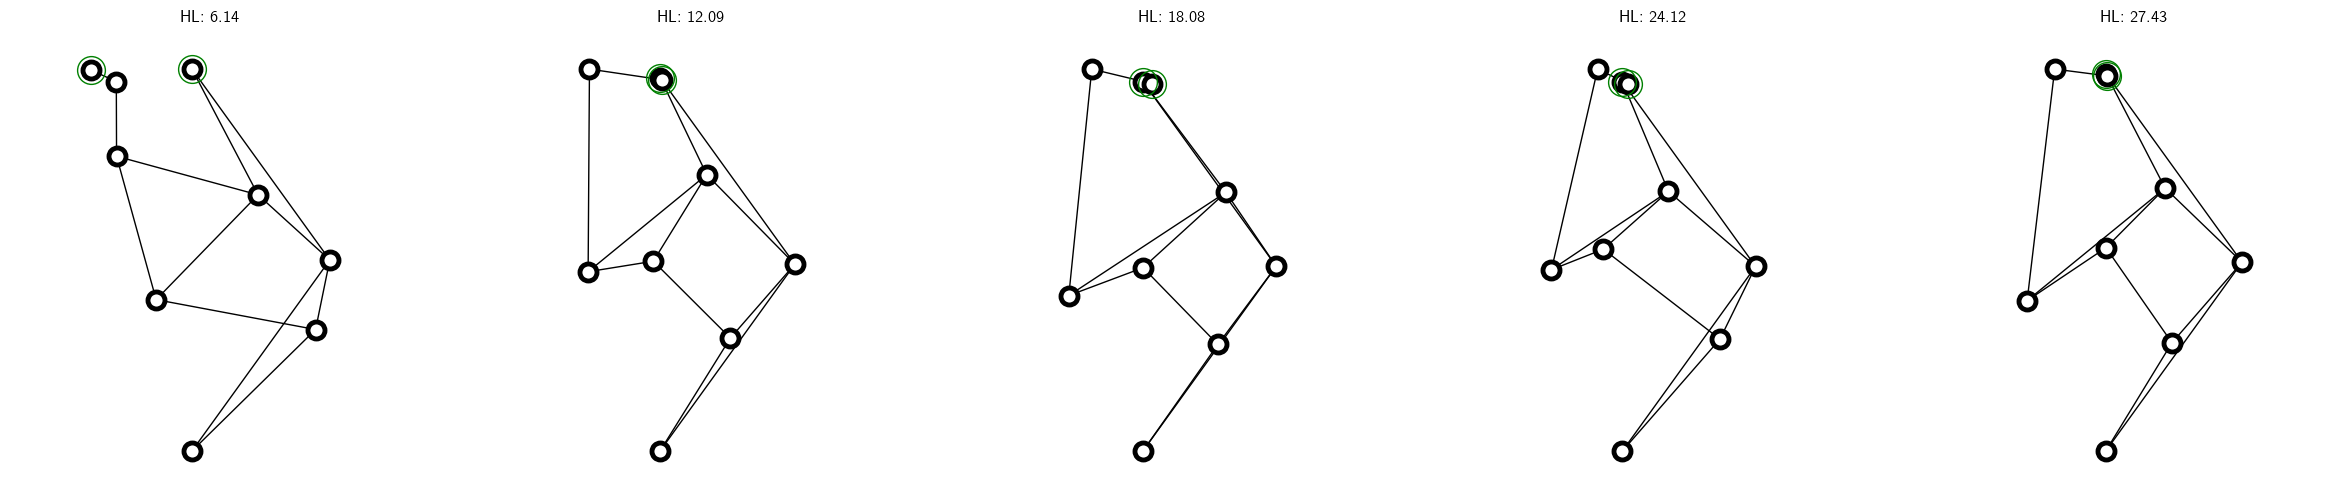

In [26]:
plt.figure(figsize=(len(HL_sorted)*6, 6))
for HL in HL_sorted:
    plt.subplot(1, len(HL_sorted), HL_sorted.index(HL) + 1)
    id_design = HL2ids_designs[HL]
    problem.mutate_JP_by_xopt(valid_HL_arr_X_srtd[id_design])
    draw_joint_point(problem.graph)
    plt.title(f"HL: {np.round(HL,2)}")
    plt.legend('',frameon=False)

plt.savefig(os.path.join(path, "HL_designs.svg"))